<a href="https://colab.research.google.com/github/nicholassolomon/Kaggle_Titanic_Competition/blob/main/Titanic_Kaggle_First.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Kaggle Titanic - Machine Learning from Diaster

* https://www.kaggle.com/c/titanic/overview

### **Steps**
1. EDA. Explore data, investigate and get info on features. See how each impacts the survival data.
 - how each feature impacts survival
 - what features to include/exclude
 - features that need to be transformed (not numerical)
 - what data is missing and impact
2. Data Preprocessing:
  - cleaning data
  - missing values
  - unique values
  - data type
  - featuer scaling
  - ways to discretise (reduce) feature -  `pd.cut()`
  - turn values into numbers `LabelEncoder()`

### **Articles**:
* **missing values**: https://www.kdnuggets.com/2022/07/scikitlearn-imputer.html
* https://medium.com/@praveen.orvakanti/this-will-help-you-score-95-percentile-in-the-kaggle-titanic-ml-competition-aa2b3fd1b79b#:~:text=So%2C%20the%20logistic%20regression%20model,score%20for%20the%20Titanic%20dataset.
* https://www.kaggle.com/code/yssefunc/best-feature-and-model-selection-for-titanic
* https://www.linkedin.com/pulse/what-i-learned-analyzing-famous-titanic-dateset-murilo-gustineli/
* https://towardsdatascience.com/kaggle-titanic-machine-learning-model-top-7-fa4523b7c40
* https://thatdatatho.com/titanic-data-set-increased-prediction-scores-82/



## Submissions

1. Based on PyCaret choice (.76)
2. Catboost() 2_2_24  (.77)
3. RandomForestClassifier (2/2/24)  (.75)

In [ ]:
# libraries
!pip install -U ydata-profiling[notebook]==4.0.0 matplotlib==3.5.1
# then restart kernel

In [ ]:
import numpy as np
import pandas as pd
from ydata_profiling import ProfileReport


## Get Datasets

In [ ]:
import os
from pathlib import Path

data_path = Path("data/")

if data_path.is_dir():
  print("Non need to download data -- alread there")
else:
  data_path.mkdir(parents=True, exist_ok=True)

# get data from book repo
!git clone https://github.com/nicholassolomon/Kaggle_Titanic_Competition.git
!mv Kaggle_Titanic_Competition/data/*.csv data
!rm -rf Kaggle_Titanic_Competition

### Profile Training Data using YData

In [ ]:
df_train = pd.read_csv('./data/train.csv')
df_test = pd.read_csv('./data/test.csv')
df_submit = pd.read_csv('./data/gender_submission.csv')


profile_train = ProfileReport(df_train, title='Titanic Training Data')
#profile_test = ProfileReport(df_test, title='Titanic Testing Data')
#profile_submit = ProfileReport(df_submit, title='Titanic Submission Data Sample')

profile_train.to_notebook_iframe()

#save to file
profile_train.to_file('Titanic Training Data EDA.html')

### Feature Details

* PassengerId.  unique ID (int) in the range from 1 to 891.  No missing.
* Survived. (int) categorical 0 = died (549), 1 = survived (342). No missing.
* Pclass (int)(passenger class). categorical: 1-3. 1=upper, 2=middle, 3=lower. No missing.
* Name (string) (passenger name). High cardinality, unique -- all different, no dupes, no missing.
* Sex (string). categorical. "male"=577, "female"=314" No missing.
* Age (float). Range from 0.42-80. 177 (20%) missing values! Mean = 29.7.
* SibSp (int) (# of siblings/spouces on board). Range 0-8. No missing. 68%=0.
* Parch (int) (# of parents/children on board). Range 0-6. No missing. 76%=0.
* Ticket (string) (ticket #). high cardinality, unique. No missing
* Fare (float) (cost of ticket). No missing. Range 0-512.32
* Cabin (string) (cabin number). categorical. Missing 78%!
* Embarked (string) (where passenger embarked). categorical. S=644, C=168, Q=77. Missing 2 values.

Features that will need to be converted to numbers:
* Sex
* Embarked

Features missing data:
* Embarked - only missing two. Drop or fill in?
* Age - 20% are missing!  Drop or fill in somehow?
* Cabin - 78% are missing!  Drop?


## Model(s)


In [1]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.4 MB/s eta 0:00:00


In [2]:
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

# Data Manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

<ipython-input-2-568ff354b1c7>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


In [3]:
# Get data
import os
import torch
from pathlib import Path

data_path = Path("data/")

if data_path.is_dir():
  print("Non need to download data -- alread there")
else:
  data_path.mkdir(parents=True, exist_ok=True)

# get data from book repo
!git clone https://github.com/nicholassolomon/Kaggle_Titanic_Competition.git
!mv Kaggle_Titanic_Competition/data/*.csv data
!rm -rf Kaggle_Titanic_Competition

# set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device


Cloning into 'Kaggle_Titanic_Competition'...
remote: Enumerating objects: 95, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (18/18), done.
remote: Total 95 (delta 8), reused 0 (delta 0), pack-reused 77
Receiving objects: 100% (95/95), 1.78 MiB | 5.93 MiB/s, done.
Resolving deltas: 100% (31/31), done.


'cuda'

In [5]:
# get pre-processed data
import pandas as pd

# use processed data from data prep notebook
df_train = pd.read_csv('/content/data/Processed_Training_Data_2_2_24.csv')
df_train.head(10)

Survived    Pclass       Sex     SibSp     Parch  Embarked  family_size  \
0         0  0.827377 -0.737695  0.432793 -0.473674 -0.568837     0.059160   
1         1 -1.566107  1.355574  0.432793 -0.473674  1.005181     0.059160   
2         1  0.827377  1.355574 -0.474545 -0.473674 -0.568837    -0.560975   
3         1 -1.566107  1.355574  0.432793 -0.473674 -0.568837     0.059160   
4         0  0.827377 -0.737695 -0.474545 -0.473674 -0.568837    -0.560975   
5         0  0.827377 -0.737695 -0.474545 -0.473674  2.579199    -0.560975   
6         0 -1.566107 -0.737695 -0.474545 -0.473674 -0.568837    -0.560975   
7         0  0.827377 -0.737695  2.247470  0.767630 -0.568837     1.919564   
8         1  0.827377  1.355574 -0.474545  2.008933 -0.568837     0.679295   
9         1 -0.369365  1.355574  0.432793 -0.473674  1.005181     0.059160   

   Singleton  SmallFamily  LargeFamily  ...  Cabin_F  Cabin_G  Cabin_T  \
0  -1.231645     1.432260    -0.273476  ...        0        0        0   
1  -1.231645     1.432260    -0.273476  ...        0        0        0   
2   0.811922    -0.698197    -0.273476  ...        0        0        0   
3  -1.231645     1.432260    -0.273476  ...        0        0        0   
4   0.811922    -0.698197    -0.273476  ...        0        0        0   
5   0.811922    -0.698197    -0.273476  ...        0        0        0   
6   0.811922    -0.698197    -0.273476  ...        0        0        0   
7  -1.231645    -0.698197     3.656633  ...        0        0        0   
8  -1.231645     1.432260    -0.273476  ...        0        0        0   
9  -1.231645     1.432260    -0.273476  ...        0        0        0   

   Cabin_U  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  \
0        1             0           0         1          0              0   
1        0             0           0         0          1              0   
2        1             0           1         0          0              0   
3        0             0           0         0          1              0   
4        1             0           0         1          0              0   
5        1             0           0         1          0              0   
6        0             0           0         1          0              0   
7        1             1           0         0          0              0   
8        1             0           0         0          1              0   
9        1             0           0         0          1              0   

   Title_Royality  
0               0  
1               0  
2               0  
3               0  
4               0  
5               0  
6               0  
7               0  
8               0  
9               0  

[10 rows x 41 columns]

In [ ]:
df_train.columns

In [6]:
# Split the dataframe into data and labels
#X_train = df_train.drop('Survived', axis=1) # data
#X_train = df_train.drop(columns=['Survived','Age_Class','Age_Class_Emb'],axis=1)
X_train = df_train.drop(columns=['Survived'],axis=1)
y_train = df_train.Survived # labels

# Shape of the data (without labels)
X_train.shape, y_train.shape

((891, 40), (891,))

In [ ]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):

    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)

    # Cross Validation
    train_pred = model_selection.cross_val_predict(algo,
                                                  X_train,
                                                  y_train,
                                                  cv=cv,
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)

    return train_pred, acc, acc_cv

In [ ]:
random_forest_model = RandomForestClassifier(n_estimators=200, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
random_forest_model.fit(X_train, y_train)
accuracy = round(random_forest_model.score(X_train, y_train) * 100, 2)

accuracy

In [ ]:
train_predictions = model_selection.cross_val_predict(estimator=random_forest_model,
                                                      X=X_train,
                                                      y=y_train,
                                                      cv=10,
                                                      n_jobs=-1)
acc_cv = round(metrics.accuracy_score(y_train, train_predictions) * 100, 2)
acc_cv


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest Classifier
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(RandomForestClassifier(),
                                                                       X_train,
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

In [ ]:
# Gradient Boosting Trees
start_time = time.time()
train_pred_gbt, acc_gbt, acc_cv_gbt = fit_ml_algo(GradientBoostingClassifier(),
                                                                       X_train,
                                                                       y_train,
                                                                       10)
gbt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gbt)
print("Accuracy CV 10-Fold: %s" % acc_cv_gbt)
print("Running Time: %s" % datetime.timedelta(seconds=gbt_time))

In [ ]:
# View the data for the CatBoost model
X_train.head()

In [ ]:
X_train.Pclass.dtype

In [ ]:
y_train.head()

In [7]:
# prompt: Get a list of all column indexes in X_train that are not np.float or np.float64

float_cols = [i for i, col in enumerate(X_train.columns) if X_train[col].dtype in [np.float, np.float64]]
non_float_cols = [i for i in range(len(X_train.columns)) if i not in float_cols]
print(non_float_cols)


[11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39]


In [8]:
# Define the categorical features for the CatBoost model
cat_features = np.where(X_train.dtypes != np.float)[0]
cat_features

array([11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
       28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39])

In [9]:
# Use the CatBoost Pool() function to pool together the training data and categorical feature labels
train_pool = Pool(X_train,
                  y_train,
                  cat_features)

In [10]:
# CatBoost model definition
catboost_model = CatBoostClassifier(iterations=1000,
                                    custom_loss=['Accuracy'],
                                    loss_function='Logloss',
                                    task_type="GPU")

# Fit CatBoost model
catboost_model.fit(train_pool,
                   plot=True)

# CatBoost accuracy
acc_catboost = round(catboost_model.score(X_train, y_train) * 100, 2)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Learning rate set to 0.033926
0:	learn: 0.6719105	total: 54ms	remaining: 53.9s
1:	learn: 0.6520978	total: 96.7ms	remaining: 48.2s
2:	learn: 0.6319338	total: 141ms	remaining: 46.8s
3:	learn: 0.6183305	total: 182ms	remaining: 45.2s
4:	learn: 0.6005463	total: 217ms	remaining: 43.2s
5:	learn: 0.5840540	total: 253ms	remaining: 41.9s
6:	learn: 0.5676718	total: 289ms	remaining: 41.1s
7:	learn: 0.5544873	total: 326ms	remaining: 40.4s
8:	learn: 0.5449797	total: 345ms	remaining: 38s
9:	learn: 0.5327186	total: 368ms	remaining: 36.5s
10:	learn: 0.5245224	total: 391ms	remaining: 35.1s
11:	learn: 0.5175589	total: 414ms	remaining: 34.1s
12:	learn: 0.5077761	total: 431ms	remaining: 32.7s
13:	learn: 0.4990721	total: 454ms	remaining: 32s
14:	learn: 0.4934416	total: 467ms	remaining: 30.7s
15:	learn: 0.4867388	total: 489ms	remaining: 30.1s
16:	learn: 0.4806038	total: 506ms	remaining: 29.3s
17:	learn: 0.4750646	total: 524ms	remaining: 28.6s
18:	learn: 0.4684305	total: 546ms	remaining: 28.2s
19:	learn: 0.46

In [11]:
acc_catboost

91.13

In [12]:
# How long will this take?
start_time = time.time()

# Set params for cross-validation as same as initial model
cv_params = catboost_model.get_params()

# Run the cross-validation for 10-folds (same as the other models)
cv_data = cv(train_pool,
             cv_params,
             fold_count=10,
             plot=True)

# How long did it take?
catboost_time = (time.time() - start_time)

# CatBoost CV results save into a dataframe (cv_data), let's withdraw the maximum accuracy score
acc_cv_catboost = round(np.max(cv_data['test-Accuracy-mean']) * 100, 2)
acc_cv_catboost

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Streaming output truncated to the last 5000 lines.
14:	learn: 0.5055105	test: 0.4933246	best: 0.4933246 (14)	total: 405ms	remaining: 26.6s
15:	learn: 0.4976145	test: 0.4849102	best: 0.4849102 (15)	total: 429ms	remaining: 26.4s
16:	learn: 0.4926468	test: 0.4783215	best: 0.4783215 (16)	total: 444ms	remaining: 25.7s
17:	learn: 0.4863215	test: 0.4711901	best: 0.4711901 (17)	total: 468ms	remaining: 25.5s
18:	learn: 0.4804888	test: 0.4653982	best: 0.4653982 (18)	total: 492ms	remaining: 25.4s
19:	learn: 0.4746641	test: 0.4589027	best: 0.4589027 (19)	total: 525ms	remaining: 25.7s
20:	learn: 0.4701342	test: 0.4543086	best: 0.4543086 (20)	total: 554ms	remaining: 25.8s
21:	learn: 0.4657989	test: 0.4482880	best: 0.4482880 (21)	total: 580ms	remaining: 25.8s
22:	learn: 0.4604212	test: 0.4429602	best: 0.4429602 (22)	total: 603ms	remaining: 25.6s
23:	learn: 0.4554579	test: 0.4389401	best: 0.4389401 (23)	total: 627ms	remaining: 25.5s
24:	learn: 0.4518998	test: 0.4339392	best: 0.4339392 (24)	total: 649m

83.84

In [13]:
# Print out the CatBoost model metrics
# 1: 91.47 (1000 iterations)
# 2: dropping several columns: 88.55 (cv 83.84)
# 3: add cabin and family size groups:  91.13 (cv 83.84)
print("---CatBoost Metrics---")
print("Accuracy: {}".format(acc_catboost))
print("Accuracy cross-validation 10-Fold: {}".format(acc_cv_catboost))
print("Running Time: {}".format(datetime.timedelta(seconds=catboost_time)))

---CatBoost Metrics---
Accuracy: 91.13
Accuracy cross-validation 10-Fold: 83.84
Running Time: 0:06:49.218904


In [14]:
# Feature Importance
def feature_importance(model, data):
    """
    Function to show which features are most important in the model.
    ::param_model:: Which model to use?
    ::param_data:: What data to use?
    """
    fea_imp = pd.DataFrame({'imp': model.feature_importances_, 'col': data.columns})
    fea_imp = fea_imp.sort_values(['imp', 'col'], ascending=[True, False]).iloc[-30:]
    _ = fea_imp.plot(kind='barh', x='col', y='imp', figsize=(20, 10))
    return fea_imp
    #plt.savefig('catboost_feature_importance.png')

imp                  col
13   0.428101       Age_Middle Age
22   0.487530             Fare_Low
20   0.499495   Fare_Extremely Low
19   0.508218  Fare_Extremely High
11   0.517435           Age_Adults
6    0.567931            Singleton
28   0.568883              Cabin_D
17   0.614275     Age_Young Adults
26   0.743606              Cabin_B
4    0.750201             Embarked
38   0.828672        Title_Officer
12   0.889172         Age_Children
24   0.925059        Fare_Very Low
7    1.175433          SmallFamily
35   1.234370           Title_Miss
29   1.478854              Cabin_E
3    1.651420                Parch
23   2.028801       Fare_Very High
2    2.044743                SibSp
37   2.129347            Title_Mrs
21   2.186942            Fare_High
33   2.503443              Cabin_U
8    2.688630          LargeFamily
34   3.559979         Title_Master
5    5.427804          family_size
0    6.671457               Pclass
36  11.329065             Title_Mr
10  11.601271        Age_Class_Emb
9   15.120362            Age_Class
1   16.842988                  Sex

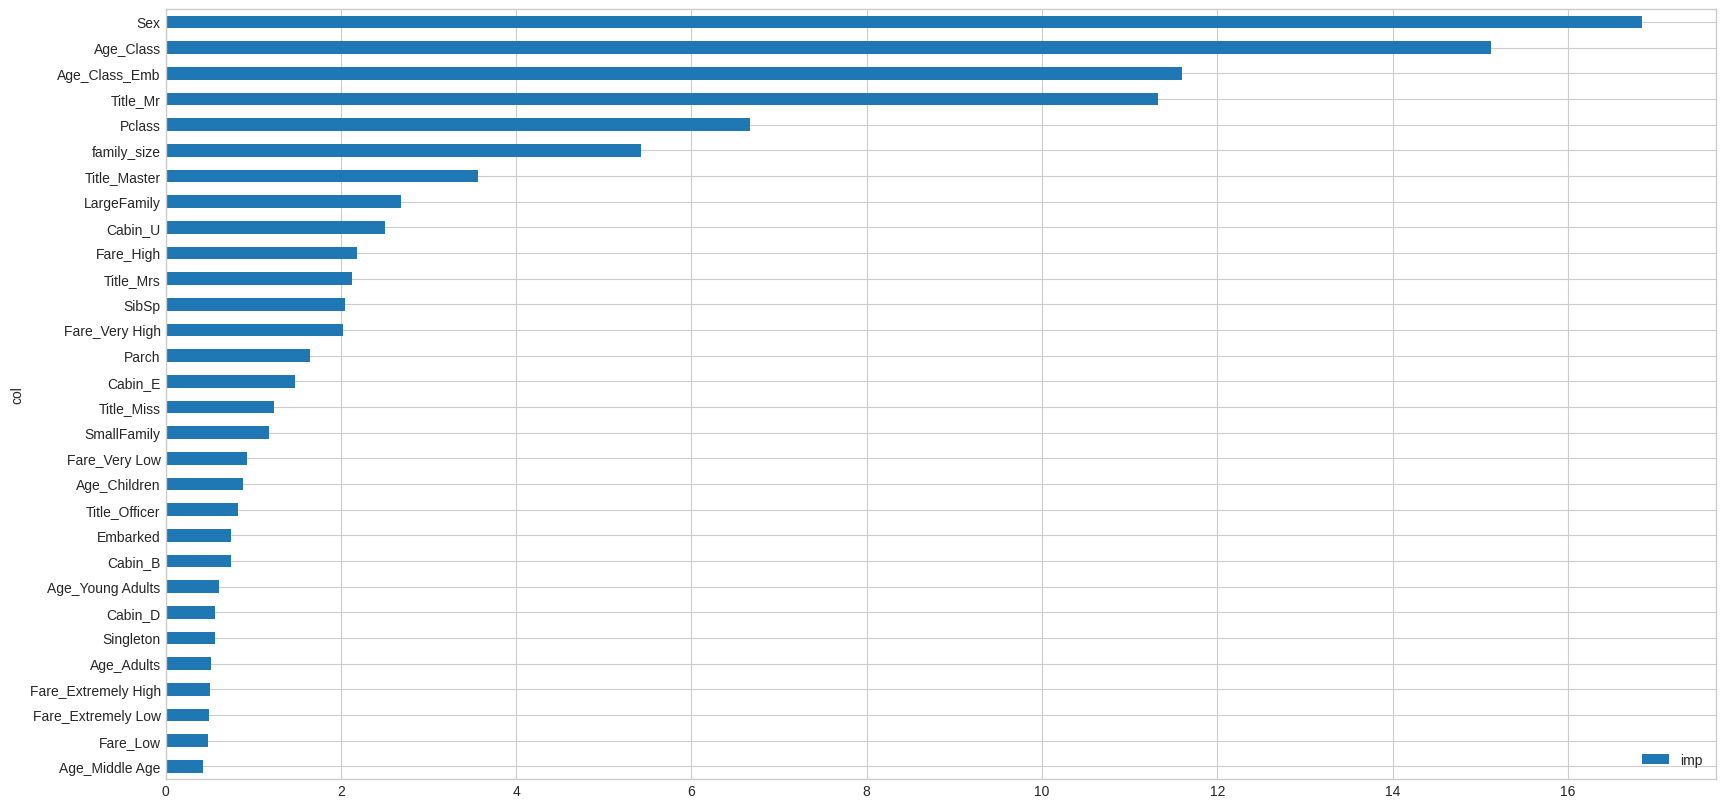

In [15]:
# Plot the feature importance scores
feature_importance(catboost_model, X_train)

In [ ]:
feature_importance()

In [16]:
from google.colab import output
output.enable_custom_widget_manager()

Support for third party widgets will remain active for the duration of the session. To disable support:

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [17]:
metrics = ['Precision', 'Recall', 'F1', 'AUC']

eval_metrics = catboost_model.eval_metrics(train_pool,
                                           metrics=metrics,
                                           plot=True)

for metric in metrics:
    print(str(metric)+": {}".format(np.mean(eval_metrics[metric])))

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Precision: 0.894966864855489
Recall: 0.8062456140350878
F1: 0.848269012267839
AUC: 0.9390065003887983


## Submission

In [18]:
# We need our test dataframe to look like this one
X_train.head()

Pclass       Sex     SibSp     Parch  Embarked  family_size  Singleton  \
0  0.827377 -0.737695  0.432793 -0.473674 -0.568837     0.059160  -1.231645   
1 -1.566107  1.355574  0.432793 -0.473674  1.005181     0.059160  -1.231645   
2  0.827377  1.355574 -0.474545 -0.473674 -0.568837    -0.560975   0.811922   
3 -1.566107  1.355574  0.432793 -0.473674 -0.568837     0.059160  -1.231645   
4  0.827377 -0.737695 -0.474545 -0.473674 -0.568837    -0.560975   0.811922   

   SmallFamily  LargeFamily  Age_Class  ...  Cabin_F  Cabin_G  Cabin_T  \
0     1.432260    -0.273476   0.046590  ...        0        0        0   
1     1.432260    -0.273476  -0.773689  ...        0        0        0   
2    -0.698197    -0.273476   0.398138  ...        0        0        0   
3     1.432260    -0.273476  -0.861576  ...        0        0        0   
4    -0.698197    -0.273476   1.189122  ...        0        0        0   

   Cabin_U  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  \
0        1             0           0         1          0              0   
1        0             0           0         0          1              0   
2        1             0           1         0          0              0   
3        0             0           0         0          1              0   
4        1             0           0         1          0              0   

   Title_Royality  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 40 columns]

In [19]:
df_test = pd.read_csv('./data/Processed_Testing_Data_2_2_24.csv')
test = pd.read_csv('./data/test.csv')
test.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [20]:
df_test['PassengerId'] = test['PassengerId']
df_test.head()

Pclass       Sex     SibSp     Parch  Embarked  family_size  Singleton  \
0  0.873482 -0.755929 -0.499470 -0.400248  2.243165    -0.553443   0.807573   
1  0.873482  1.322876  0.616992 -0.400248 -0.677841     0.105643  -1.238278   
2 -0.315819 -0.755929 -0.499470 -0.400248  2.243165    -0.553443   0.807573   
3  0.873482 -0.755929 -0.499470 -0.400248 -0.677841    -0.553443   0.807573   
4  0.873482  1.322876  0.616992  0.619896 -0.677841     0.764728  -1.238278   

   SmallFamily  LargeFamily  Age_Class  ...  Cabin_E  Cabin_F  Cabin_G  \
0    -0.728790    -0.224168   0.024362  ...        0        0        0   
1     1.372137    -0.224168   1.231254  ...        0        0        0   
2    -0.728790    -0.224168  -0.327649  ...        0        0        0   
3    -0.728790    -0.224168   1.004962  ...        0        0        0   
4     1.372137    -0.224168   1.004962  ...        0        0        0   

   Cabin_U  Title_Master  Title_Miss  Title_Mr  Title_Mrs  Title_Officer  \
0        1             0           0         1          0              0   
1        1             0           0         0          1              0   
2        1             0           0         1          0              0   
3        1             0           0         1          0              0   
4        1             0           0         0          1              0   

   PassengerId  
0          892  
1          893  
2          894  
3          895  
4          896  

[5 rows x 39 columns]

In [21]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
wanted_test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'family_size',
       'Singleton', 'SmallFamily', 'LargeFamily', 'Age_Class', 'Age_Class_Emb',
       'Age_Adults', 'Age_Children', 'Age_Middle Age', 'Age_Retired',
       'Age_Senior', 'Age_Teens', 'Age_Young Adults', 'Age_Youngsters',
       'Fare_Extremely High', 'Fare_Extremely Low', 'Fare_High', 'Fare_Low',
       'Fare_Very High', 'Fare_Very Low', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_T', 'Cabin_U',
       'Title_Master', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer',
       'Title_Royality'],
      dtype='object')

In [22]:
test_columns = df_test.columns
test_columns

Index(['Pclass', 'Sex', 'SibSp', 'Parch', 'Embarked', 'family_size',
       'Singleton', 'SmallFamily', 'LargeFamily', 'Age_Class', 'Age_Class_Emb',
       'Age_Adults', 'Age_Children', 'Age_Middle Age', 'Age_Retired',
       'Age_Senior', 'Age_Teens', 'Age_Young Adults', 'Age_Youngsters',
       'Fare_Extremely High', 'Fare_Extremely Low', 'Fare_High', 'Fare_Low',
       'Fare_Very High', 'Fare_Very Low', 'Cabin_A', 'Cabin_B', 'Cabin_C',
       'Cabin_D', 'Cabin_E', 'Cabin_F', 'Cabin_G', 'Cabin_U', 'Title_Master',
       'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'PassengerId'],
      dtype='object')

In [24]:
# Catboost Predictions
# Make a prediction using the CatBoost model on the wanted columns\
# drop Cabin_T and Title_Royality form columns
wanted_test_columns = wanted_test_columns.drop(['Cabin_T', 'Title_Royality'])
predictions = catboost_model.predict(df_test[wanted_test_columns])

CatBoostError: Invalid cat_features[27] = 38 value: index must be < 38.

In [ ]:
# RandomForest Predictions
random_forest_predictions = random_forest_model.predict(df_test[wanted_test_columns])
random_forest_predictions[:10]

In [ ]:
# Our predictions array is comprised of 0's and 1's (Survived or Did Not Survive)
predictions[:20]

In [ ]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

In [ ]:
# create one for random forest
random_forest_submission = pd.DataFrame()
random_forest_submission['PassengerId'] = test['PassengerId']
random_forest_submission['Survived'] = random_forest_predictions # our model predictions on the test dataset
random_forest_submission.head()

In [ ]:
# Are our test and submission dataframes the same length?
if len(random_forest_submission) == len(test):
    print("Submission dataframe is the same length as test ({} rows).".format(len(random_forest_submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

In [ ]:
# Convert submisison dataframe to csv for submission to csv
# for Kaggle submisison
random_forest_submission.to_csv('./data/randomn_forest_submission_2_2_24.csv', index=False)
print('Submission CSV is ready!')